# Danish Politics: Tweeting vs. meeting

Authors: Christian Engelbrekt Petersen, Frederik Kromann Hansen & Lau Johansson

# Motivation

## Imports

In [241]:
import pickle
import tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')


import math

from PIL import Image


import community

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Describe datasets (goal -> what is dataset -> how does it answer goal)

### Twitter

On [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/), twitterprofiles of 650 danish politicians has been collected. This will be the basis of the network. Each of the profiles should represent a node. 



The project uses tweets from Twitter in order to make a network which connects danish politicians. 

In order to get tweets, a developer account for twitter has been created. Tweet can then be assesed through Twitters API on https://developer.twitter.com/en.



### Politicians (parties and regions)

### Political meetings

# Basic stats

## Data cleaning

### Twitterprofiles

Initially all of the twitterprofiles are collected using the webpage https://filip.journet.sdu.dk/twitter/politikere/.

In [ ]:
from tqdm.notebook import tqdm
URL = 'https://filip.journet.sdu.dk/twitter/politikere/'
page = requests.get(URL)

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')


After inspecting the webpage, is it concluded that all twitternames are displayed in < h3 > classes. 

In [ ]:
twitter_names = soup.find_all('h3')

Creating a list to save all the twitter names.

In [ ]:
twitter_name_list=[]

Scraping all of the names from the webpage:

In [ ]:
for names in twitter_names:
    match=re.search("<h3>#",str(names))
    if match:
        result_name=re.findall(".com/\w*",str(names))[0].replace(".com/","")
        twitter_name_list.append(result_name.rstrip())
        #print(result_name)

For each of the twitternames (twitterprofiles) a corresponding real name is shown. The real politician names are displayed in < small > classes. Initially a empty list for all the names are created.

In [ ]:
real_name_list=[]

Thereafter, the webpage are scraped in order to find the realnames:

In [ ]:
real_names = soup.find_all('small')
for r_names in real_names:
    result=re.search(r'<small>.+',str(r_names)).group(0).replace("<small>","")
    real_name_list.append(result.rstrip())
    print(result)

All of the twittername with their corresponding real names are saved into a pandas dataframe.

In [ ]:
d={'Names':real_name_list,"Twittername":twitter_name_list}
data=pd.DataFrame(data=d)

In [ ]:
#data.to_csv("danish_politkere_twitter.csv") #For saving the file for later use

In [ ]:
data.head()

This can be used to easily load the data:

In [2]:
data=pd.read_csv("danish_politkere_twitter.csv")

### Tweets (who tags who)

From twitter the only profiles needed is the politicians which just have been scraped.

The twitternames are saved in a list.

In [3]:
twitter_name_list=list(data["Twittername"])

For using the API, both API key, API secret key, access token and access token-secret is needed. For privacy matter, these has been saved in files saved locally. The code below shows how the data are imported from our computers.

In [4]:
User='Lau'

In [5]:
#Load keys (everytime except first)
with open('api_key_'+User+'.data', 'rb') as filehandle:
    api_key = pickle.load(filehandle) 
with open('api_key_secret_'+User+'.data', 'rb') as filehandle:
    api_secret_key = pickle.load(filehandle)
with open('access_token_'+User+'.data', 'rb') as filehandle:
    access_token = pickle.load(filehandle)
with open('access_token_secret_'+User+'.data', 'rb') as filehandle:
    access_token_secret = pickle.load(filehandle)

For accessing twitter data, the library Tweepy has been used. Since only tweets from the politicians are needed, tweepy is very suitable for doing the job. Here is a link to the library webpage: https://www.tweepy.org/

Creating the API object which uses [OAuth](https://oauth.net/) for secure authorization. It enables interaction with the twitter API. 

In [6]:
# Creating the authentication object
auth = tweepy.OAuthHandler(api_key, api_secret_key)
# Setting access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

To give a small introduction on how it works, below 5 tweets from the politician Margrethe Vestager is printed.

In [9]:
# The Twitter user who we want to get tweets from
name = "vestager"
# Number of tweets to pull
tweetCount = 5

# Calling the user_timeline function with our parameters
tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

# foreach through all tweets pulled
for tweet in tweets:
    # printing the text stored inside the tweet object
    print(tweet.full_text)
    print(80 * '-')

Lights are on tonight for each and every woman that suffered violences. Physically or emotionally. Down the streets or online. No matter where. We stand united to end #ViolencesAgainstWomen #IDEVAW 🙏 https://t.co/mGFyMtYdI3
--------------------------------------------------------------------------------
Great strategy! https://t.co/ES5q8SwIgx
--------------------------------------------------------------------------------
Today tabling the #DataGovernanceAct. We want to create the right conditions for people, companies and authorities to share data in a secure, trust creating manner. If they want to share!
--------------------------------------------------------------------------------
Fascinating and needed #Sentinel6 6 will help us understand both the causes &amp; the consequences of climate change. #SafeTravel https://t.co/BYzp2h31sx
--------------------------------------------------------------------------------
RT @vonderleyen: We have signed our 5th contract with a vaccine produc

The structure of dictionary is as follows:


* Vestager :
       Larslokke : [tweettextA, tweettextB] 
       oestergaard : [tweettextC] 


Each key correspond to a politician twitter profiles e.g. Vestager. Vestager has tagged Larslokke in two tweets and oestergaard in one tweet.

In [10]:
tweet_dict={"Dummy":{}} #The dummy is deleted later

Saving all the twitterprofiles (again).

In [7]:
 all_persons=list(data["Twittername"])

The following code uses Tweepy to the last 200 tweets (the limit of the API) of each politician. 

If politician (P0) tags another politician (P1), then P1 is saved, and a corresponding list with all tweets where P0 mentions P1 is also saved.  

In [ ]:
n_count=0
n_total=len(all_persons)
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        if name not in list(tweet_dict.keys()):
            ##Updating dict with the new politician if it is not there
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in twitter_name_list:
                            
                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))

Delete the dummy:

In [327]:
del tweet_dict["Dummy"]

Saving all data:

In [328]:
#with open('tweet_dict_listversion.data', 'wb') as filehandle:
#    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

Some of the politicians could perhaps mention eachother without using the tag (@). Therefore, the amount of data is increased by including mentioning of politicians full names. Here's an example:

vestager tweets: "Morten Østergaard try to read this post, how (...)"

Morten Østergaard's twittername is oestergaard, and therefore, this tweet should be related to the twitterprofile "oestergaard". 

To attach the tweet to the corresponding twittername, the twitternames are saved in a list:

In [9]:
twitter_name_list=list(data["Twittername"])

The real names in the data is a combinaed of low letters and capital letters. All names are then lower-cased, and saved in a list:

In [10]:
data["Names"]=data["Names"].str.lower() ##LAVER DEM TIL LOWER
names_list=list(data["Names"])

When Morten Østergaards twittername shall be found, it can be done like this:

In [11]:
data[data["Names"]=="morten østergaard"]["Twittername"]

2    oestergaard
Name: Twittername, dtype: object

All the tweets of the politicians are then revised, and the following code adds the tweets which has a real name included:

In [ ]:

n_count=0
n_total=len(three_persons)
for p in three_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict, if the politician has (by some reason) been "visited" before
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})



        ###############========== FINDING TWEETS FOR PERSON=============#####

        for i,tweet in enumerate(tweets):
        
                #Save the tweet, but this time lowering the text
                opslag=tweet.full_text.lower()


                #Loop through all real names for the 650 politicians
                for real_names in names_list:
                    
                    if real_names in opslag:
                        twittername=data[data["Names"]==real_names]["Twittername"] #Find the persons twittername
                        twittername=list(twittername)[0] #"hack" for removing pandas "objecttype"


                        #If the politician P0, has not mentioned politician P1 before
                        if twittername not in list(tweet_dict[name].keys()):
                            tweet_dict[name].update({twittername:[opslag]}) 
                        else:
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            tweet_dict[name][twittername].append(opslag)
    except:
        print("Error at {}".format(name))

In [ ]:
#Saving the dat locally
#with open('tweet_dict_listversion_wrealnames.data', 'wb') as filehandle:
#    pickle.dump(tweet_dict, filehandle)

The dictionary called "tweet_dict" now contains data on (almost) all the politicians and who they have been tagging including the assosicated tweets.

During the datapreparation, some of the API calls of the twitterprofiles failed. These were:

* SosseSass -> He has changed name to SassLarsen 
* Simonpihl -> He has a private twitterprofile
* GeertsenVenstre -> He has changed name to Martin_geertsen
* BendixenPebe -> She has maybe deleted/deactivated her profile. No new profile has been found.
* ToftJakobsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* simonsjsimonsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* Latifa_Venstre -> She has maybe deleted/deactivated her profile. No new profile has been found.
* GlenMadsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* flemse68 -> He has a private twitterprofile
* SkovAndersen -> He has changed name to KristianSkov21
* rn_lehmann -> He has maybe deleted/deactivated his profile. No new profile has been found.



SosseSass, GeertsenVenstre and SkovAndersen is handled by doing the following in the dataset:

* SosseSass is changed to SassLarsen.
* GeertsenVenstre is changed to Martin_geertsen
* SkovAndersen is changed to KristianSkov21


In [17]:
data.loc[data['Twittername']=="SosseSass","Twittername"]="SassLarsen"
data.loc[data['Twittername']=="GeertsenVenstre","Twittername"]="Martin_geertsen"
data.loc[data['Twittername']=="SkovAndersen","Twittername"]="KristianSkov21"

In [18]:
three_politicians=["SassLarsen","Martin_geertsen","KristianSkov21"]

All instances of the three politicians twitter names in the dictionary should be updated too:

In [ ]:
with open('tweet_dict_listversion_wrealnames.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [19]:
for elem in list(tweet_dict.keys()):
    for elem2 in list(tweet_dict[elem].keys()):            
        if elem2=="SosseSass":
            tweet_dict[elem]["SassLarsen"] = tweet_dict[elem].pop("SosseSass")
        if elem2=="GeertsenVenstre":
            tweet_dict[elem]["Martin_geertsen"] = tweet_dict[elem].pop("GeertsenVenstre")
        if elem2=="SkovAndersen":
            tweet_dict[elem]["KristianSkov21"] = tweet_dict[elem].pop("SkovAndersen")

In [ ]:
#with open('tweet_dict_listversion_wrealnames.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

Then the code for collecting tweets are runned again, but only focusing on the three politicians above. (The new implmentation is at codeline 40):

In [20]:
n_count=0
n_total=len(all_persons)
for p in all_persons not in three_politicians:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict with the new politician
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in three_politicians:
                            
                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))

Loading 1 / 651
Loading 2 / 651
Loading 3 / 651
Loading 4 / 651
Loading 5 / 651
Loading 6 / 651
Loading 7 / 651
Loading 8 / 651
Loading 9 / 651
Loading 10 / 651
Loading 11 / 651
Loading 12 / 651
Loading 13 / 651
Loading 14 / 651
Loading 15 / 651
Loading 16 / 651
Loading 17 / 651
Loading 18 / 651
Loading 19 / 651
Loading 20 / 651
Loading 21 / 651
Loading 22 / 651
Loading 23 / 651
Loading 24 / 651
Loading 25 / 651
Loading 26 / 651
Loading 27 / 651
Loading 28 / 651
Loading 29 / 651
Loading 30 / 651
Loading 31 / 651
Loading 32 / 651
Loading 33 / 651
Loading 34 / 651
Loading 35 / 651
Loading 36 / 651
Loading 37 / 651
Loading 38 / 651
Loading 39 / 651
Loading 40 / 651
Loading 41 / 651
Loading 42 / 651
Loading 43 / 651
Loading 44 / 651
Loading 45 / 651
Loading 46 / 651
Loading 47 / 651
Loading 48 / 651
Error at SosseSass
Loading 49 / 651
Loading 50 / 651
Loading 51 / 651
Loading 52 / 651
Loading 53 / 651
Loading 54 / 651
Loading 55 / 651
Loading 56 / 651
Loading 57 / 651
Loading 58 / 651
Load

Loading 451 / 651
Loading 452 / 651
Loading 453 / 651
Loading 454 / 651
Loading 455 / 651
Loading 456 / 651
Loading 457 / 651
Loading 458 / 651
Loading 459 / 651
Loading 460 / 651
Loading 461 / 651
Loading 462 / 651
Loading 463 / 651
Loading 464 / 651
Loading 465 / 651
Loading 466 / 651
Loading 467 / 651
Loading 468 / 651
Loading 469 / 651
Loading 470 / 651
Error at flemse68
Loading 471 / 651
Loading 472 / 651
Loading 473 / 651
Loading 474 / 651
Loading 475 / 651
Loading 476 / 651
Loading 477 / 651
Loading 478 / 651
Loading 479 / 651
Error at SkovAndersen
Loading 480 / 651
Loading 481 / 651
Loading 482 / 651
Loading 483 / 651
Loading 484 / 651
Loading 485 / 651
Loading 486 / 651
Loading 487 / 651
Loading 488 / 651
Loading 489 / 651
Loading 490 / 651
Loading 491 / 651
Loading 492 / 651
Loading 493 / 651
Loading 494 / 651
Loading 495 / 651
Loading 496 / 651
Loading 497 / 651
Loading 498 / 651
Loading 499 / 651
Loading 500 / 651
Loading 501 / 651
Loading 502 / 651
Loading 503 / 651
Loadin

Also adding all the politicians who the three politicians has mentioned from their new profiles (new implmentation at code line 3):

In [28]:
n_count=0
n_total=len(three_politicians)
for p in three_politicians:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict with the new politician
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):

                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:

                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")

                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in all_persons:

                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))

Loading 1 / 3
Loading 2 / 3
Loading 3 / 3


In [ ]:
#with open('tweet_dict_listversion_wrealnames_v2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

**Conlusion:** The dictionary called "tweet_dict" now contains data on all the politicians which the API could asses. Furthermore the dictionary contains information about who they have been tagging including the associated tweets.

## Tweets (only the text)

To faciliate the topic modelling analysis and wordcloud generation, all of the last 200 tweets from each of the politicians is saved in a dictionary. The keys are politician twitternames and the values are a list of all the tweets. 

In [ ]:
tweet_dict_onlytext={"Dummy":{}}

In [ ]:
n_count=0
n_total=len(all_persons)
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))

    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict
        tweet_dict_onlytext.update({name:{}})

        ###############========== FINDING TWEETS FOR PERSON=============#####
        for i,tweet in enumerate(tweets):
            opslag=tweet.full_text
            if i==0:
                tweet_dict_onlytext[name]=[opslag]
            else:
                tweet_dict_onlytext[name].append(opslag)
    except:
        print("Error at {}".format(name))        

In [ ]:
del tweet_dict["Dummy"]

In [ ]:
#with open('tweet_dict_all_v2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict_onlytext, filehandle)

**Conclusion:** All of the politicians respectively 200 tweets are saved in a dictionary "tweet_dict_onlytext"

### Politicians (parties and regions)

### Political meetings

## Preliminary statistics

### Text statistics (twitter and meetings)

#### Twitter text statistics (who mentions who)

In [4]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

Using pandas dataframe to get an easier overview of the politicians and their associated mentioned politicians.

In [405]:
pd_tweet_dict=pd.DataFrame.from_dict(tweet_dict)

Transposing the dataset, so the politician who has made the tweet is represented in the rows - the ones who are mentioned are represented in coloumns. NaNs in place (i,j) means that the politician *i* does not mention politician *j*.

In [406]:
pd_tweet_dict=pd_tweet_dict.transpose()

In [407]:
pd_tweet_dict.head(2)

,SchaldemoseMEP,karmel80,oestergaard,sofiecn,vestager,simonkollerup,jesper_bedreby,RohlChristopher,Statsmin,_MaiMercado,...,Eeahaldan,8464tage,Lindaf_dk,PetterAstrup,NiniOken,KarstenUno,SimickMorten,hedlund_susan,VickyLorenzen,birgitte_vind
vestager,[#HybridDebate @SchaldemoseMEP: What is illega...,[#HybridDebate @SchaldemoseMEP: What is illega...,"[@oestergaard @radikale @sofiecn Ja, @sofiecn ...","[@oestergaard @radikale @sofiecn Ja, @sofiecn ...",[RT @NATOpress: #NATO Secretary General @jenss...,[RT @simonkollerup: Deltog i erhvervsministern...,[Opening the upper secondary section of @Schol...,[RT @RohlChristopher: Prideweek starter i dag ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
larsloekke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[@CasparStrand @Statsmin Tillykke!!],[@_MaiMercado Ulækkert!],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [408]:
print("The number of Twitter profiles who is found on twitter: {}".format(pd_tweet_dict.shape[0]))

The number of Twitter profiles who is found on twitter: 643


In [409]:
print("The number of Twitter profiles who is mentioned: {}".format(pd_tweet_dict.shape[1]))

The number of Twitter profiles who is mentioned: 499


In [410]:
print("The number of distinct links between politicians: {}".format(pd_tweet_dict.count().sum()))

The number of distinct links between politicians: 10445


In [411]:
print("The number of no-links from a poltician to another: {}".format(pd_tweet_dict.isna().sum().sum()))

The number of no-links from a poltician to another: 310412


There's 310412 combinations of politicians where theres no mentioning on twitter. This indicates a very sparse matrix. When later using this as a basis for a graph, one would know that it is not a complete graph. 

The following piece of code revise the dictionary again and calculates:
* The total number of tweets accross all politicians (non-distinct, because multiple politician can be mentioned in same tweet)
* Total length of all the tweets
* A list for every politician, indicating the length of the each tweets where they mentions other politicians
* A list for every politician, indicating the total length all tweets where they mentions other politicians
* A number for every politician, indicating the total number of tweets

In [442]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=0
    
    for to_pol in list(tweet_dict[pol].keys()):
        elems=tweet_dict[pol][to_pol]
        
        #sum over the number of words for each tweet
        elems_splittet_to_words=[elems[i].split() for i in range(len(elems))]
        total_string_length+=sum( map(len,elems_splittet_to_words  )) #Summing the total length of character
        total_n_tweets+=len(elems)                  # summing the total number of tweets
        
        n_tweet_dict[pol]+=len(elems)
        
        #Save all length of tweets
        for e in elems:
            tweet_lengths_all_dict[pol].append(len(e.split()))
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])

In [443]:
print("The total number of tweets {}".format(total_n_tweets))

The total number of tweets 33532


In [444]:
print("The average length of tweets {}".format(total_string_length/total_n_tweets))

The average length of tweets 24.760616724323036


Making a histogram over the sum of the length of all tweets for all politicians using Sturge's rule for the number of bins:

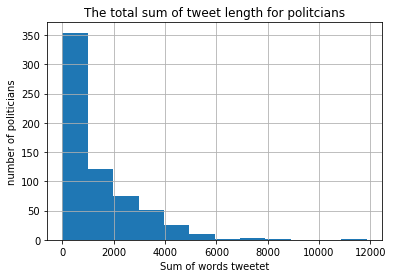

In [438]:
pd.DataFrame(tweet_length_agg_dict.values()).hist(bins=12)
plt.title("The total sum of tweet length for politcians")
plt.ylabel('number of politicians')
plt.xlabel('Sum of words tweetet')
plt.show()

Most of the politicians has a tweetet in total, where others are mentioned, between 0 and 1000 words.

Plot the distribution of the length of the tweets (again using Sturge's rule).

In [434]:
list2d=list(tweet_lengths_all_dict.values())

In [435]:
import itertools
merged = list(itertools.chain(*list2d))

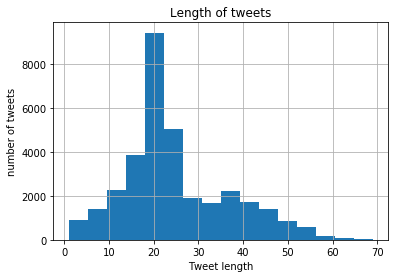

In [436]:
pd.DataFrame(merged).hist(bins=16)
plt.title("Length of tweets")
plt.ylabel('number of tweets')
plt.xlabel('Tweet length')
plt.show()

Most of the tweets where politician mentions other politicians is around 20 words long. 

In [ ]:
Plotting the distribution 

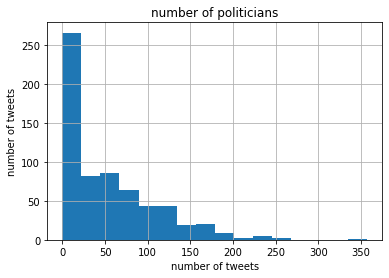

In [441]:
pd.DataFrame(list(n_tweet_dict.values())).hist(bins=16)
plt.title("number of politicians")
plt.ylabel('number of tweets')
plt.xlabel('number of tweets')
plt.show()

The most of the politicians has between 0 and 25 tweets.

#### Twitter text statistics (last 200 tweets for every politician)

Loading the tweets:

In [45]:
with open('tweet_dict_all_v2.data', 'rb') as filehandle:
    tweet_dict_onlytext = pickle.load(filehandle) 

The number of twitter profiles who tweets:

In [46]:
len(list(tweet_dict_onlytext.keys()))

642

The tweets of 642 of the politicians has correctly been collected.

Preparing statistics:

In [47]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict_onlytext.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=len(tweet_dict_onlytext[pol])
    total_n_tweets+=len(tweet_dict_onlytext[pol])
    
    
    for elems in list(tweet_dict_onlytext[pol]):
        elems_splittet_to_words=elems.split()
        tweet_lengths_all_dict[pol].append(len(elems_splittet_to_words))
        
        total_string_length+=len(elems_splittet_to_words)        
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])

In [48]:
print("The total number of tweets {}".format(total_n_tweets))

The total number of tweets 83663


In [49]:
print("The average length of tweets {}".format(total_string_length/total_n_tweets))

The average length of tweets 22.032176708939435


Making a histogram over the sum of the length of all tweets for all politicians using Sturge's rule for the number of bins:

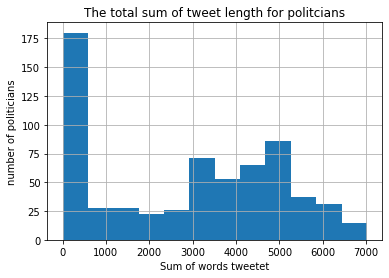

In [50]:
pd.DataFrame(tweet_length_agg_dict.values()).hist(bins=12)
plt.title("The total sum of tweet length for politcians")
plt.ylabel('number of politicians')
plt.xlabel('Sum of words tweetet')
plt.show()

Most of the politicians has a tweetet in total between 0 and 500 words.
Then a "normal"-like distribution occur with min around 2000 and max around 7000. Theres a spike around 5000 words tweetet.

Plot the distribution of the length of the tweets (again using Sturge's rule).

In [51]:
list2d=list(tweet_lengths_all_dict.values())

In [52]:
import itertools
merged = list(itertools.chain(*list2d))

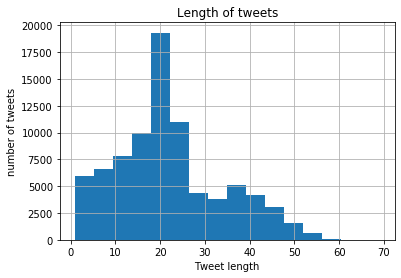

In [53]:
pd.DataFrame(merged).hist(bins=16)
plt.title("Length of tweets")
plt.ylabel('number of tweets')
plt.xlabel('Tweet length')
plt.show()

In [54]:
max(merged)

69

Most of the tweets where is around 20 words long and the distribution-tail flattens out with a maximum at 69 words.

The API has a limit of 200 tweets, but not all politicians neccesarily has tweetet 200 times. 
Plotting the distribution of number of tweets collected.

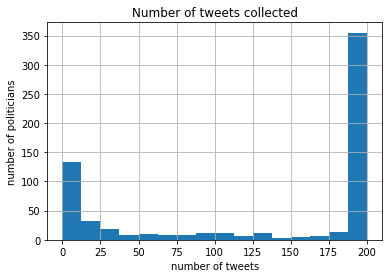

In [55]:
pd.DataFrame(list(n_tweet_dict.values())).hist(bins=16)
plt.title("Number of tweets collected")
plt.ylabel('number of politicians')
plt.xlabel('number of tweets')
plt.show()

In [56]:
np.quantile(list(n_tweet_dict.values()),0.25)

20.25

In [59]:
np.quantile(list(n_tweet_dict.values()),0.5)

199.0

In [57]:
a=np.array(list(n_tweet_dict.values()))

In [58]:
np.count_nonzero(a == 200)

312

25% of the politicians has 20 or less tweets, but over 50% has 200 tweets.
312 politicians have 200 tweets. 

#### Meetings text statistics

### Network statistics

The generation of the network is based on the previous generated dictionary from [Tweets-(who-tags-who)](#Tweets-(who-tags-who)) section. 

In [ ]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

When a politician e.g Lars Løkke, mentions another politicians e.g. Morten Østergaard, the two politicians are connected. Each politician represent a node in the graph. The mentioning using a "@" makes alink from Lars to Morten, which gives a directed edge from Lars to Morten. Morten does not neccesarily mention Lars in any posts - therefore, to incoporate the complexity of mentioning in Twitter, a directed graph is chosen for the social politician Twitter network.

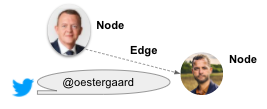

In [32]:
from IPython.display import Image
Image(filename='images/lars_mention_oster.png')

For generating a graph representing the network of twitter politicians, the NetworkX library is used. The library makes it possible to create a empty directed graphs, and one by one add connections (edges) between the politicians. The labels of the nodes are the politicians' twitternames.

Create the directed graph:

In [35]:
G=nx.DiGraph()

Make edge from tweeting politicinas to the ones that they mentions. Before generating the network, it is assumed that if Lars mentions Morten in e.g. 12 tweets, then the edge from Lars to Morten has a weight value of 12.

If Lars then only mentions Margrethe Vestager 3 times, the edge from Lars to Vestager is 3. 

The weight $W_{ij}$ in the graph therefore represent the number of times politician (node) *i* mentions politician (node) *j*.

The weight for a edge is then calculated by finding the length of the list of tweets where politician *i* mentions politician *j*.


In [36]:
for pol in list(tweet_dict.keys()): #All politician, i
    for to_pol in list(tweet_dict[pol].keys()): #All that i mentions, j
            if G.has_edge(pol, to_pol):
                # If there's already a edge, print a error
                print("error")
            else:
                G.add_edge(pol, to_pol, weight=len(tweet_dict[pol][to_pol]))

Save/load file locally:

In [48]:
#nx.write_gpickle(G, "second_network_w_weights_listversion_wrealnames_v2.gpickle")
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

Having created the graph, we can now look into the first statistics of the network. 

In [41]:
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

The number of nodes: 561
The number of edges: 10445


Out of the 650 politicians, 561 of them has mentioned another politician or has been mentioned. Between all of the nodes theres 10445 weighted edges.

To get the first glance of the network, networkx is used for plotting the graph. The size of the nodes is in this plot dependent of the degree.  

In [79]:
d = dict(G.degree(G.nodes()))

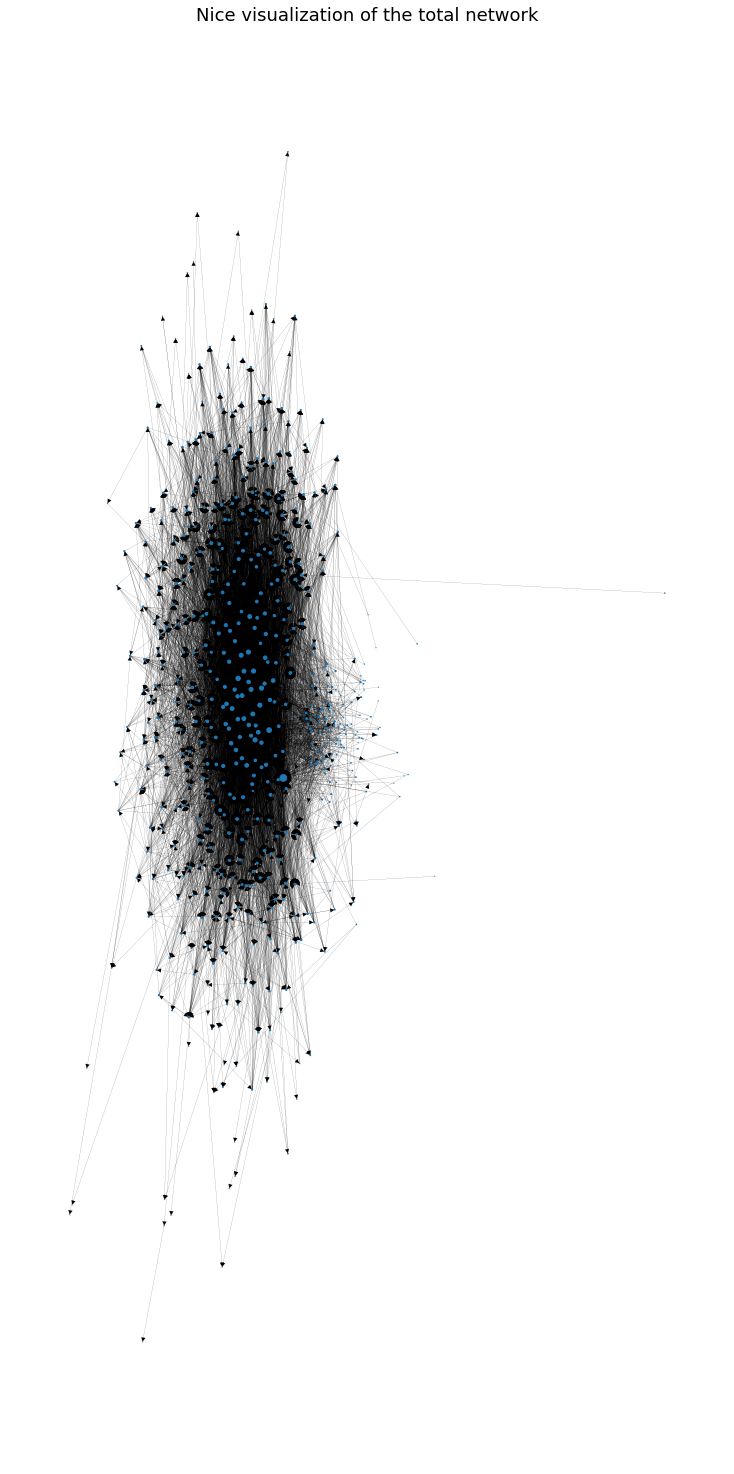

In [80]:
plt.figure(figsize=(10,20))
nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d.values()], width=0.1)

plt.title("Nice visualization of the total network",fontsize=18)
plt.show()

Networkx has a tool to give the weighted node degree. From [networkx.DiGraph.degree](https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.degree.html): "The weighted node degree is the sum of the edge weights for edges incident to that node.". Thereby the degree of a node/Politician depends on the number of Tweets the politician has been mentioned in. If the weight has not been used.

In [82]:
d_weight = dict(G.degree(G.nodes(),'weight'))

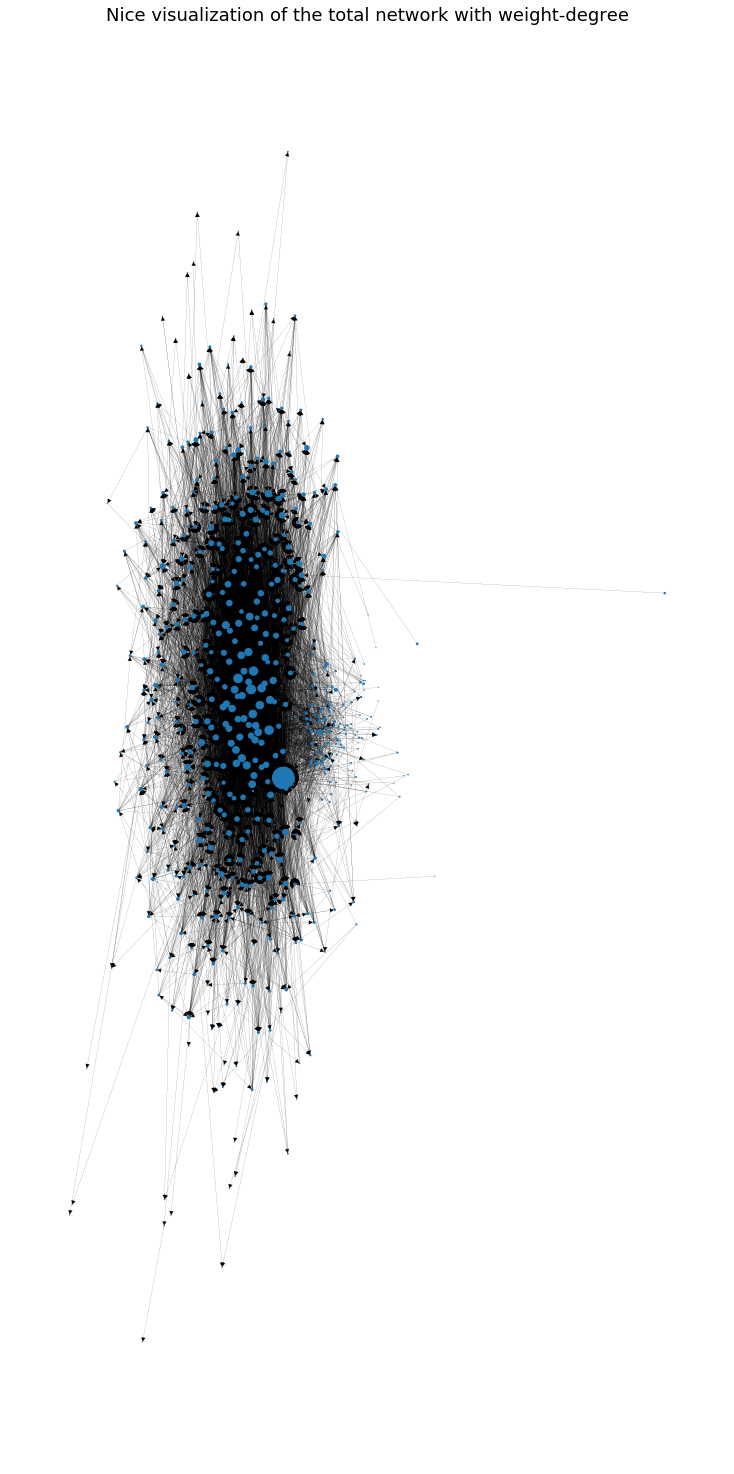

In [83]:
plt.figure(figsize=(10,20))
nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d_weight.values(), width=0.1)

plt.title("Nice visualization of the total network with weight-degree",fontsize=18)
plt.show()

The use of weighted degree has a clear impact on the graph. Looking at Vestager again, the degree value increases by around 85%.

In [113]:
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [170]:
start=list(dict(G.degree(["vestager"])).values())[0]
print(start)

48


In [171]:
end=list(dict(G.degree(["vestager"],'weight')).values())[0]
print(end)

89


In [172]:
get_change(end,start)

85.41666666666666

Vestager's node in_degree difference between a non-weighted and a weighted is 85.4%. Finding all the difference between all politicians degree and weighted degree:

In [173]:
deg_deff_dict={}
for node in list(G.nodes()):
    start=list(dict(G.degree([node])).values())[0]
    end=list(dict(G.degree([node],'weight')).values())[0]
    deg_deff_dict.update({node:get_change(end,start)})

Looking at the highest differences:

In [174]:
sorted(deg_deff_dict.items(), key=lambda x: x[1], reverse=True)[0:5]

[('Forsvarsmin', 1150.0),
 ('HolmerHans', 1128.5714285714287),
 ('regeringDK', 933.6263736263737),
 ('MortenSkovlund', 833.3333333333334),
 ('LiselotteLyngeJ', 804.3478260869565)]

In [182]:
print("regeringDK degree: {}".format(G.degree("regeringDK")))
print("HolmerHans degree: {}".format(G.degree("HolmerHans")))

regeringDK degree: 455
HolmerHans degree: 7


In [183]:
print("regeringDK degree: {}".format(G.degree("regeringDK",'weight')))
print("HolmerHans degree: {}".format(G.degree("HolmerHans",'weight')))

regeringDK degree: 4703
HolmerHans degree: 86


The danish parliament has its own twitterprofile, which apparently has a lot of mentions. With a degree of 455 it implicates that the profile is very connected. But including the weight it is even more obvoius that alot of tweets from a lot of politicians mentions "regeringDK"

HolmerHans is Chairman of Social and Health at Kolding City Council. Using only the non-weighted degree, the importance of this twitterprofile could might be underestimated. When accounting for the number of tweets (weight) he suddenly become very actively in the social twitter network.

**Conclusion:**

With 561 danish politicians, connected by 10445 edges a directed graph representing a "Social network of danish politicians on Twitter" has been created. The graph is directed do to the distinction between politician A mentioning politician B, and the other way around. Using a weighted directed graph emphasizes the importance on the number of tweets on Twitter. 

# Tools, theory and analysis

## Overall idea

## Analysis step 1: Network 

This project aims to build models that reproduce the properties of real networks. To examine whether the graph reproduces a real network or it is just a random network, the degree distribution of a random network is compared to the Twitter network. 

By examining the properties of the Twitter network, there can be shed light on how politicians can influence each other. This project assumes, that a politician is interested to know how to influence others most effectively and how to spred a message to the public including the other politicians. 

In the following section degree-distributions are going to be plotted. For this purpose the code below can plot a customade histogram. For plotting an appropiate amount of bins [Sturge's formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) is applied. The number of bins is equal to $\lceil log_{n}\rceil +1$, where *n* is the total number of observations.

In [35]:
def custom_histogram(list_of_values,title_name,x_label,y_label):
    
    #Sturges rule for number of bins
    n_bin=math.ceil(math.log2(len(list_of_values)))+1
    
    hist,bin_edges=np.histogram(list_of_values,bins=n_bin)

    rightboundary=bin_edges[1:]
    leftboundary=bin_edges[:-1]
    newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
    newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
    for i in range(len(rightboundary)):
        newlist_in.append(leftboundary[i])
        newvalues_in.append(hist[i])
        newlist_in.append(rightboundary[i])
        newvalues_in.append(hist[i]) 
    points_in=zip(newlist_in,newvalues_in)


    plt.figure(figsize=(8,8))
    plt.plot(newlist_in,newvalues_in,color='#0504aa')
    for pt in points_in:
        plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )

    plt.title(title_name,fontsize=18)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.show()

Next, the in- and out-degree of the graph is assesed. This is done in order to get an idea of how the politicians are connected.

In [32]:
list_in=list(dict(G.in_degree()).values()) # This is all of the nodes' degrees
list_out=list(dict(G.out_degree()).values()) # This is all of the nodes' degrees

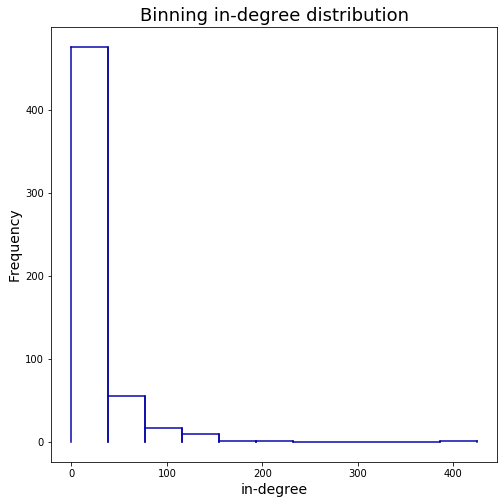

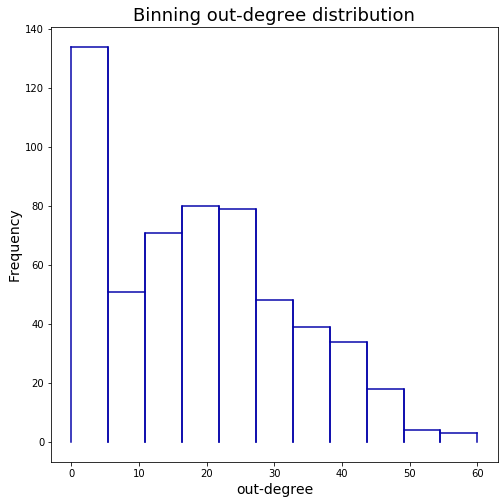

In [36]:
custom_histogram(list_in,"Binning in-degree distribution","in-degree","Frequency")
custom_histogram(list_out,"Binning out-degree distribution","out-degree","Frequency")

From [Network Sciencebook - Chapter 3, sec. 3.2](http://networksciencebook.com/chapter/3):
"A random network consists of N nodes where each node pair is connected with probability p."

To calculate the probability p of the Politician Twitter Network, the average degree, k, is found. From [Network Sciencebook - Chapter 3, sec. 3.3](http://networksciencebook.com/chapter/3#random-network) eq. 3.3 the following holds:

$k = p ( N-1)$

so $p = \frac{k}{N-1}$

Since *k* is equal to the average degree, networkx can calculate the value:

In [92]:
k=np.mean(list(dict(G.degree()).values())) 
print(k)



###Should we use the weighted???

#k=np.mean(list(dict(G.degree(G.nodes(),'weight')).values())) 
#print(k)

37.23707664884135


The number of nodes:

In [82]:
N=G.number_of_nodes()

The probability of each pair of nodes is connected:

In [83]:
p=k/(N-1)
print(p)

0.06649477973007384


Generating the random graph from extracted parameters

In [55]:
G_ER=nx.erdos_renyi_graph(N,p,directed=True) 

Plotting the degree distribution for the ER graph.

In [57]:
list_in_r=list(dict(G_ER.in_degree()).values()) # This is all of the nodes' degrees
list_out_r=list(dict(G_ER.out_degree()).values()) # This is all of the nodes' degrees

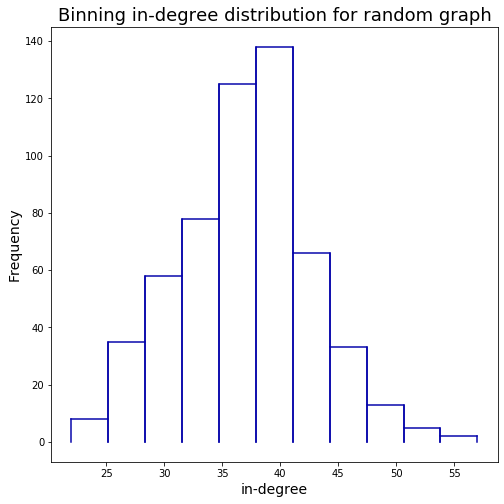

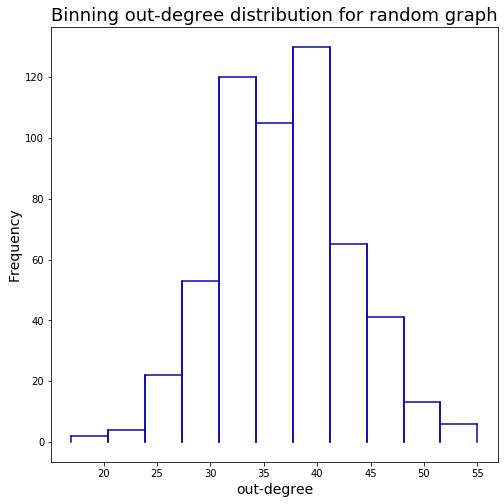

In [58]:
custom_histogram(list_in_r,"Binning in-degree distribution for random graph","in-degree","Frequency")
custom_histogram(list_out_r,"Binning out-degree distribution for random graph","out-degree","Frequency")

**Conclusion:**

Comparing the distribution of the twitter network and a random graph, it can be concluded, that there a difference in the degree distribution. 

The twitter network is in-degree distribution is more right skewed than the random network. 
Even though, the twitter network out-degree has a more normal-like distribution strucutre, there's still a big spike at out-degree between 0 and 5.  

### Using the giant component

The generated network should be representing the Danish Politicians Twitter network - therefore, it should not be "just" a random graph. 

The main difference between a random graph and a scale-free network, is the HUBS. According to [Network Science Book - section 5.2](http://networksciencebook.com/chapter/5) new nodes in most real networks prefers tolink to the more conencted node. This process is "preferential attachment" Preferential attachment and growth, are the two properties of the emerging of scale-free network. Scale-free networks are networks, which degree distribution is different than the degree distribution of a random network.

The probability of two nodes linking, influence the structure of the graph. There are two extreme cases. If p=0, there's zero probability that any node link to another - all nodes are isolated. If p=1, there's 100% probability that any node link to another - the graph is complete, all nodes links to each other. To get insight into how the politcian Twitter network strucures itself and why, the folllowing analysis will examine the link-probability and number of nodes. Once the average node degree exceeds a critical value, the rapid emergence of a large cluster that we call the giant component occurs. 

There are four different topological distinct regimes according to [Network Science Book - section 3.6](http://networksciencebook.com/chapter/3#evolution-network). One can distinguish between them by looking at their characteristics - more specifically on the relation between p and N. 

In [75]:
print(p >math.log(N)/N)

True


The regime is a connected regime , because p>ln(N)/N. This indicates that the twitter network will emerge to a giant component, which aborbs all nodes and components. 

According to [Network Science Book - section 3.7](http://networksciencebook.com/chapter/3#networks-supercritical) most networks are supercritical. But e.g. the real network of Actors is in the connected regime. The twitter network of politicians properties are therefore consistent with the some of the properties of other real world networks. 

The critical point seperates the regime where theres is a giant component from the one wheres there's not.
For the network to be at a critical point k, the average node degree, must be equal to 1. This also means that pc=1/N.

In [94]:
pc=1/(N-1) 
print("{:.4f}".format(pc))

0.0018


The linking probability for the twitter network must be 2% for the network to be at the critical point. If the the probability is 2% or lower, all of the politicians are connected in small components. In the aspect of the influence of politics, the twitter network will then become much more "useless" for a politician if the linking probability was lower. To get further analyze the giant component of the twitter network, the giant component can be extracted using networkx.

The algorithm for finding the giant component (and also later using forceatlas to make nice visualizations) needs the graph to be undirected.

In [49]:
G_undirected=G.to_undirected()

Extract the giant component.

In [50]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
giant_directed=G.subgraph(Gcc[0])
giant = G_undirected.subgraph(Gcc[0])
d = dict(giant.degree) #Saves the degree for making the nodesize depended of the degreee in plots

In [66]:
print("The number of nodes: {}".format(giant_directed.number_of_nodes()))
print("The number of edges: {}".format(giant_directed.number_of_edges()))

The number of nodes: 555
The number of edges: 10439


The giant component contained 555 politicians out of 561. This shows how almost all politicians are absorbed in the giant component. Below is a visualization of the component.

In [41]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:19<00:00, 101.84it/s]

BarnesHut Approximation  took  3.64  seconds
Repulsion forces  took  14.23  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.43  seconds
AdjustSpeedAndApplyForces step  took  0.42  seconds


/Users/LauJohansson/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


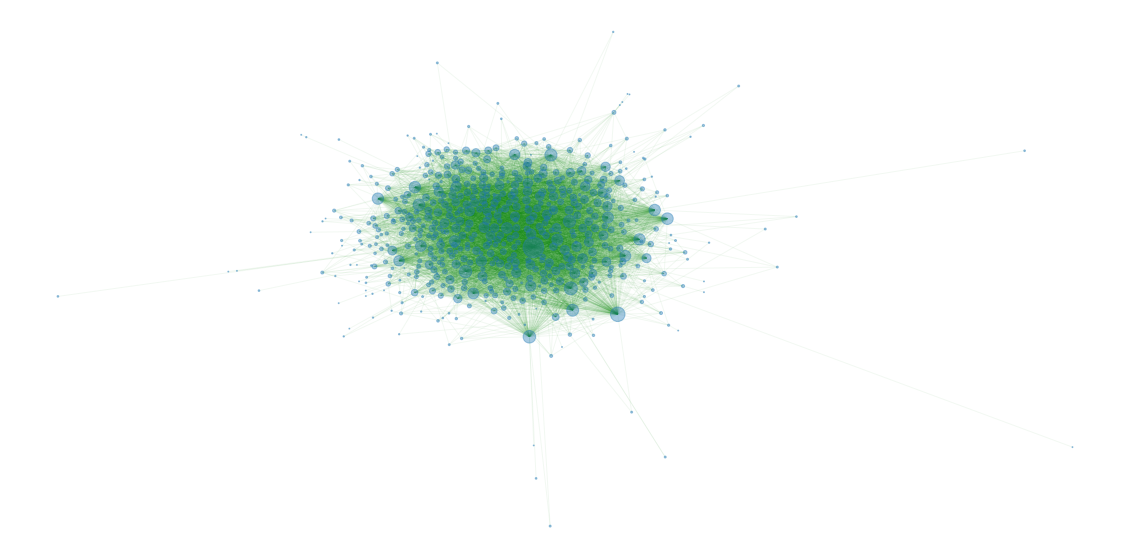

In [42]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [95]:
#list_in=list(dict(giant_directed.in_degree()).values()) # This is all of the nodes' degrees
#list_out=list(dict(giant_directed.out_degree()).values()) # This is all of the nodes' degrees

In [96]:
#custom_histogram(list_in,"Binning in-degree distribution for giant component","in-degree","Frequency")

In [97]:
#custom_histogram(list_out,"Binning out-degree distribution for giant component","out-degree","Frequency")

According to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) the degrees of a random network follows a possion distribution. Therefore, a random network is generated, and the distribution of the degrees can be compared in a normal scale and log-log scale.

Generating the random graph by initially finding N and p for the graph:

In [221]:
k_giant=np.mean(list(dict(giant.degree()).values())) 
print(k_giant)

37.61801801801802


The number of nodes:

In [109]:
N_giant=giant.number_of_nodes()

The probability of each pair of nodes is connected:

In [110]:
p_giant=k_giant/(N_giant-1)
print(p_giant)

0.059947311932871505


Generating the random graph from extracted parameters.

In [111]:
G_r = nx.generators.fast_gnp_random_graph(N_giant,p_giant)

degree_freq_r = nx.degree_histogram(G_r)
degrees_r = range(len(degree_freq_r))

Plotting the random graph degree distribution and the giant component graphs degree.

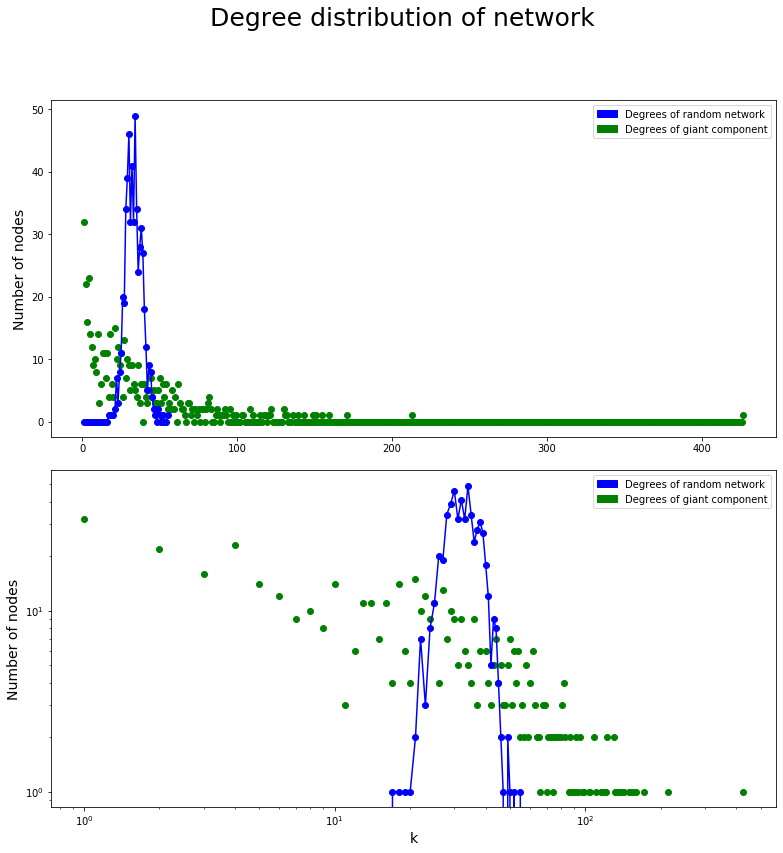

In [118]:


fig, axs = plt.subplots(2,figsize=(13,13))
fig.suptitle('Degree distribution of network',size=25)
m=1

degree_freq = nx.degree_histogram(giant)
degrees = range(len(degree_freq))

#####PLOT 1##########
axs[0].plot(degrees[m:], degree_freq[m:],'go')
axs[0].plot(degrees_r[m:], degree_freq_r[m:],'bo-')
green1_patch = mpatches.Patch(color='g', label='Degrees of giant component')
blue1_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[0].legend(handles=[blue1_patch,green1_patch])


###PLOT 2 ######
axs[1].loglog(degrees[m:], degree_freq[m:],'go')
axs[1].loglog(degrees_r[m:], degree_freq_r[m:],'bo-')
green2_patch = mpatches.Patch(color='g', label='Degrees of giant component')
axs[1].legend(handles=[green2_patch])
blue2_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[1].legend(handles=[blue2_patch,green2_patch])



axs[0].set_ylabel('Number of nodes',fontsize = 14)
axs[1].set_xlabel('k',fontsize = 14)
axs[1].set_ylabel('Number of nodes',fontsize = 14)

plt.subplots_adjust(hspace=0.1)

**Conclusion:**
To yet examine the randomness, the above plots can be inspected. On the log-log plot, the degree distribution of the giant component, the power law follows a approximately straight line. The giant component of the twitter network, is therefore different from the poisson distribution (random network). Since the Twitter network follows the power-law, is is therefore according to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) a **scale-free network**. 


A property of a scale-free network, is the nature of preferential attachment. This affects the degree of the largest node, so new politicians joining danish politics (and Twitter) will prefer to connect to some of the hubs in the network. One or few large hubs connects to most of the notes, which can represent some of the most influental twitter-profiles. Or, at least be a great potential source of bringing a message. The graph is in the connecte regime, and the giant component of the twitter network absorbs all nodes. Therefore, all politicians are somehow connected in the twitter network - the next question is then: "How are they connected?" "Who should a politician address in order to cement a polical agenda?"


### HOUSE OF CARDS - The danish politician version

"Who should a politician address in order to cement a polical agenda?"

This case is called "House of Cards"...

If a few politicians on twitter connects to many others, then these could potentially have a great influence on formation of the public opinion - and maybe also the opinion of other politicians. 

If a politician should indirectly address a person through twitter, by talking to a person who knows a person who knows a person..., it is interesting to know what the greatest distance in the network is. This is the same as the diameter of the graph. 

In [223]:
nx.diameter(giant)

6

Between any two politicians, the maximum number of people connecting the two, is 6. This number is actually quite interesting, because [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds) describes the "Small World Phenomenon": that two individuals anywhere on Earth, you will find a path of at most six acquaintances between them. The twitter network giant has only 555 nodes, so the distance between any two nodes should probably be less than 6. [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds)  states that:

< k > nodes should be at distance one

$< k >^{2}$ nodes should be at distance two

$< k >^{3}$ nodes should be at distance three...

where < k > is the average degree.

In [114]:
print("<k>: {}".format(k_giant))
print("<k>^2: {}".format(math.pow(k_giant,2)))

<k>: 33.21081081081081
<k>^2: 1102.9579547114683


This means, that almost all politicians should be in a distance of 2 from eachtoher. The average shortest path can shed more light on this:

In [235]:
nx.average_shortest_path_length(giant)
#nx.average_shortest_path_length(giant_directed)

2.0173057534068364

As expected, the average shortest path between two politicians in the twitter network is approx. 2. 

The average shortest path of the twitter network confirms, that small world phenomeom holds for the Danish Twitter Network. The following demonstration shows how a random politician are (almost) 2 nodes away from all other.

This code can generate a plot for finding and visualizing nodes that are *d* nodes away from a node:

In [137]:
#Generate video
#https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

def plot_d_step_away(node_name,graph,d,color_for_nodes,plotting="yes"):
    #Saves the shortest path
    values=np.array(list(nx.single_source_shortest_path_length(giant,node_name).values()))
    nodess=np.array(list(nx.single_source_shortest_path_length(giant,node_name).keys())) 
    
    #Making a bool-list which detects if the path (or steps) are equal to d:
    steps2= [True if element==d else False for element in values]
    
    #The bool-list can then select the nodes which are d steps away:
    
    nodes2=nodess[steps2]
    
    
    
    color_map = []
    for node in giant:
        if node == node_name:
            color_map.append('green')
        elif node in nodes2:
            color_map.append(color_for_nodes) 
        else: 
            color_map.append('grey')  
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with "+color_for_nodes +"coloured nodes "+str(d)+" steps away",fontsize=18)
        plt.show()
    
    return color_map

    
    

Choosing a random politician:

In [125]:
import random
rc=random.choice(list(giant.nodes()))

In [126]:
print(rc)

StemClausson


Finding the nodes that are 2 nodes away:

In [138]:
c_map=plot_d_step_away(rc,giant,2,"red",plotting="no")

In [130]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:18<00:00, 106.99it/s]


BarnesHut Approximation  took  3.38  seconds
Repulsion forces  took  13.62  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.41  seconds
AdjustSpeedAndApplyForces step  took  0.41  seconds


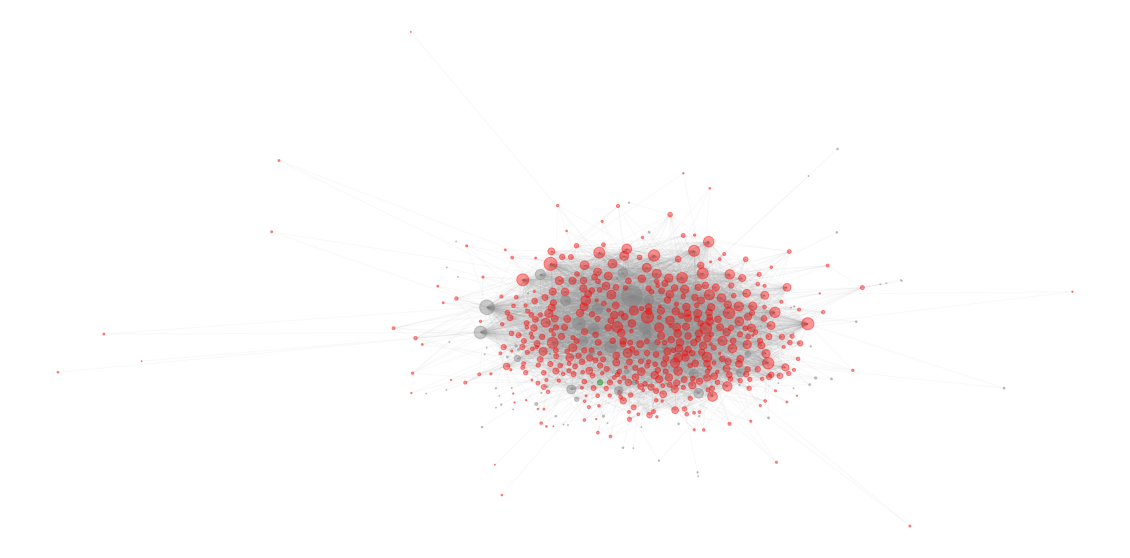

In [139]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()],node_color=c_map)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
plt.axis('off')
plt.show()

Finding the nodes that are 3 nodes away:

In [140]:
c_map2=plot_d_step_away(rc,giant,3,"blue",plotting="no")

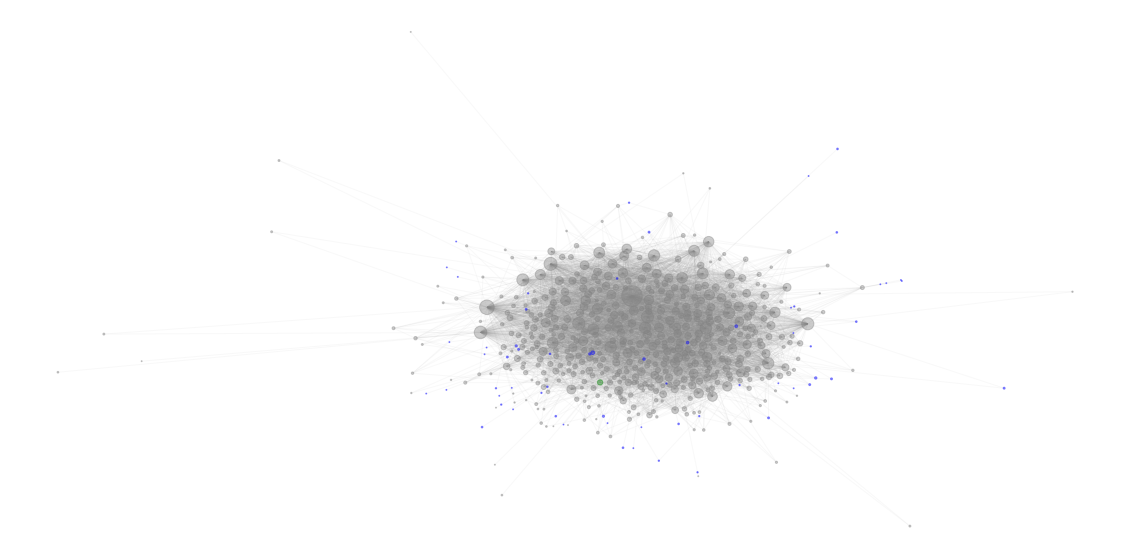

In [141]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()],node_color=c_map2)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
plt.axis('off')
plt.show()

In [145]:
c_map3=[]

for i in range(len(c_map)):
    if c_map[i]=="red":
        c_map3.append("red")
    elif c_map2[i]=="blue":
        c_map3.append("blue")
    elif c_map[i]=="green":
        c_map3.append("green")
    else:
        c_map3.append("grey")
    

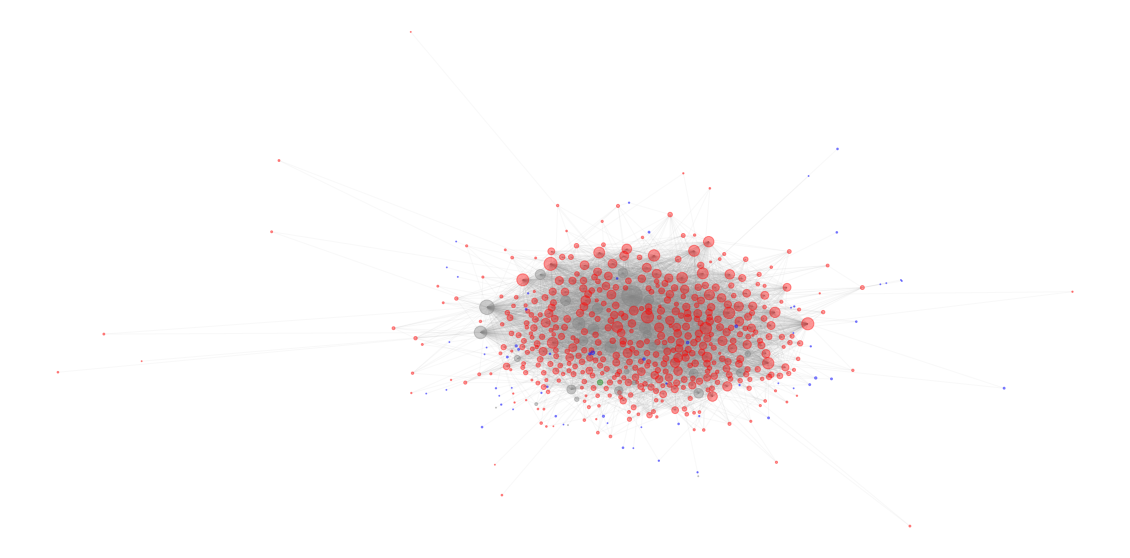

In [146]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()],node_color=c_map3)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
plt.axis('off')
plt.show()

Plot colors for all nodes that are *d* distance away.

In [236]:
#Generate video
#https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

def plot_d_step_away_all(node_name,graph,plotting="yes"):
    #Saves the shortest path
    
    dic=nx.single_source_shortest_path_length(giant,node_name)
    
    mx=max(dic, key=dic.get)
    mx=dic[mx]
    
    color_list=["red","blue","purple","orange","pink","brown"] #diameter is 6, so only 6 colors
      
    
    color_map = []
    alpha_list=[]
    for node in list(graph.nodes()):
        if node == rc:
            color_map.append('green')
            alpha_list.append(0.3)
        else:
            color_map.append(color_list[dic[node]-1]) 
            alpha_list.append(dic[node]*0.2)
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with coloured nodes d steps away",fontsize=18)
        patch1 = mpatches.Patch(color='r', label='1 step away')
        patch2 = mpatches.Patch(color='b', label='2 step away')
        patch3 = mpatches.Patch(color='purple', label='3 step away')
        patch4 = mpatches.Patch(color='orange', label='4 step away')
        patch5 = mpatches.Patch(color='pink', label='5 step away')
        patch6 = mpatches.Patch(color='brown', label='6 step away')
        
        plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
        
        
        plt.show()
    
    return color_map, alpha_list

    
    

In [237]:
c_map_all,alpha_list=plot_d_step_away_all(rc,giant,plotting="no")

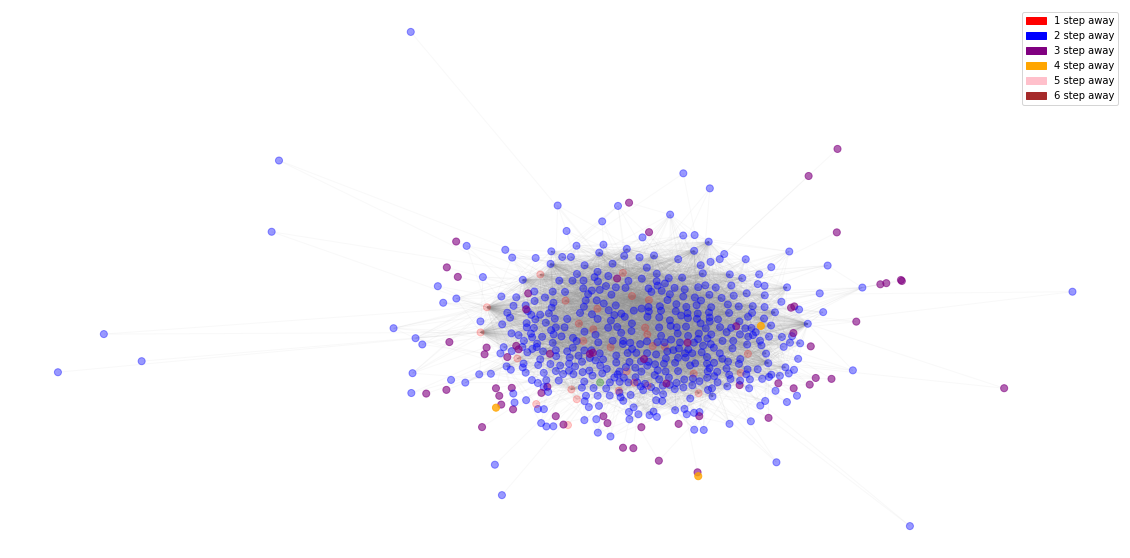

In [242]:
plt.figure(figsize=(20,10))
#nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_size=[v * 1 for v in d.values()],node_color=c_map_all)

nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_color=c_map_all,node_size=50)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
patch1 = mpatches.Patch(color='r', label='1 step away')
patch2 = mpatches.Patch(color='b', label='2 step away')
patch3 = mpatches.Patch(color='purple', label='3 step away')
patch4 = mpatches.Patch(color='orange', label='4 step away')
patch5 = mpatches.Patch(color='pink', label='5 step away')
patch6 = mpatches.Patch(color='brown', label='6 step away')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
plt.axis('off')
plt.show()

Lets say, that a random politician wants to influence one of the most central, according to degree centrality:

In [225]:
sorted(giant_directed.degree(), key=lambda x: x[1], reverse=True)[0:5]

[('regeringDK', 455),
 ('larsloekke', 217),
 ('JakobEllemann', 191),
 ('Kristian_Jensen', 174),
 ('oestergaard', 173)]

Lets take "larsloekke", then the random politicians shortest path for influence "larsloekke". Here, it is assumed, that if "larsloekke" mentions politician A, then politican A can influence "larsloekke" or at least "larsloekke" explicit "interacts" with person A. 

In [230]:
print(nx.shortest_path(giant_directed, source="larsloekke", target=rc))
print("length: " +str(len(nx.shortest_path(giant_directed, source="larsloekke", target=rc))))

['larsloekke', 'JakobEllemann', 'Danielpanduro', 'mariannefrede20', 'StemClausson']
length: 5


From the random person, StemClausson, to larsleokke, there are 3 persons between. StemClausson should then tal with mariannefrede20, in order to try to influence "larsloekke". 

Another advantage of having the network is, that if StemClausson can NOT directly talk to larsloekke, then he can might talk to some of larsloekke's inner circle. For this purpose, a politician should find the neighboors of larsloekke: 

In [227]:
[n for n in giant_directed.neighbors('larsloekke')]

['Statsmin',
 '_MaiMercado',
 'JakobEllemann',
 'SorenPape',
 'RasmusJarlov',
 'BjBrandenborg',
 'Kristianthdahl',
 'Jesper_Pet',
 'rasmusnordqvist',
 'FrankJensenKBH',
 'LouiseElholm',
 'JanEJoergensen',
 'larsloekke',
 'RStoklund',
 'regeringDK']

StemClausson can then contact one of the above persons, and hope they can influence larsloekke.

What if StemClausson want to influence a random politician? Lets draw a random.

In [232]:
rc2=random.choice(list(giant.nodes()))

In [233]:
print("The random politician is: " +rc2)

The random politician is: RasmusNorupC


In [245]:
sp=nx.shortest_path(giant_directed, source=rc2, target=rc)
print(sp)
print("length: " +str(len(sp)))

['RasmusNorupC', 'PSkipperEL', 'Danielpanduro', 'mariannefrede20', 'StemClausson']
length: 5


In [ ]:
sp.reverse() #Reverse the list

In [261]:
print("From "+rc +" to "+rc2 +"the following persons should talk with eachother \n"+'\ntalks to...'.join(sp))

From StemClausson to RasmusNorupCthe following persons should talk with eachother 
StemClausson
talks to...mariannefrede20
talks to...Danielpanduro
talks to...PSkipperEL
talks to...RasmusNorupC


## Analysis step 2: Parties and wordclouds

## Analysis step 3: Community detection and wordclouds

## Analysis step 4:  Parliament+twitter topics

## Analysis step 5: Sentiment

## Analysis step 6: Tying together

# Discussion

Mette Frederiksen er feks ikke med...


# Constributions

"You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain)."

In [ ]:
#If degree weight should in the light of these results in fact also depend on the in_degree. One could assume that 

#Maybe the weights should be normalized by the number of edges conneting to the node

In [122]:
#d_weight = dict(G.degree(G.nodes(),'weight'))

In [123]:
#d_in = dict(G.in_degree(G.nodes()))

In [130]:
#d_norm=dict()
#for node in list(d_weight.keys()):
#    if d_in[node]==0:
#        d_norm.update({node:d_weight[node]})
#    else:
#        d_norm.update({node:d_weight[node]/d_in[node]})
            

In [137]:
#start=list(dict(G.degree(["vestager"])).values())[0]
#print(start)
#end=list(dict(G.degree(["vestager"],'weight')).values())[0]
#print(end)

In [138]:
#d_norm["vestager"]

In [139]:
#plt.figure(figsize=(10,20))
#nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d_norm.values()], width=0.1)

#plt.title("Nice visualization of the total network with normalized weight-degree",fontsize=18)
#plt.show()